# Author's Notes

May 2021 Update: Support for TensorFlow 2. Note that the results in this notebook differ from those in the book because of randomness in the seed we have set here vs. the original seed for TensorFlow and numpy in the book. This is expected. I encourage you to experiment on your own by changing the seed for TensorFlow and numpy in this notebook.

Note for Mac users: You will need to use the "tensorflow_mac" Conda environment for this notebook instead of the "unsupervisedLearning" Conda environment. Please refer to the README on the GitHub repo for more.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 9 - Semi-supervised Learning

# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning


# Import Libraries

In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

## Check library versions & set seed

In [3]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')
print(f'lightgbp   {lgb.__version__}')

sklearn    0.22.2.post1
tensorflow 2.4.1
keras      2.4.0
numpy      1.19.5
lightgbp   2.2.3


In [4]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

# Data Preparation 

## Load the data 

In [5]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'credit_card_data', 'credit_card.csv'])
data = pd.read_csv(current_path + file)

In [6]:
# Create X matrix
dataX = data.copy().drop(['Class','Time'],axis=1)

# Create y Matrix
dataY = data['Class'].copy()

## Split into train and test

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
                                    dataX, dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [8]:
# Shape of data
print([x.shape for x in (X_train, X_test, y_train, y_test)])

[(190820, 29), (93987, 29), (190820,), (93987,)]


In [9]:
# Number of negative and positive examples
np.sum(y_train==0),np.sum(y_train==1)

(190490, 330)

## Scale the data 

In [10]:
# Suppress warnings
pd.set_option('mode.chained_assignment', None)

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

## Drop 90% of the labels from the training set

In [11]:
# Drop 90% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

## Check the number of fraudulent cases left after dropping 90% of the cases

In [12]:
# Check the number of fruadulant cases left after dropping 90% 
np.sum(y_train==0),np.sum(y_train==1)

(190490, 33)

## Define evaluation function and plotting function

In [13]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [14]:
# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], 
                               preds['anomalyScore'])
    average_precision = average_precision_score( 
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], 
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

## Define a new function to assess precision at a given recall threshold

In [15]:
# Define new function to assess precision at a given recall threshold
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

# Supervised Model 

In [16]:
# Create 5 k-fold sets
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [17]:
# LightGBM parameters
params_lightGB = {
    'task': 'train',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': -1,
    'num_threads':16
}

In [18]:
# Train and Evaluate Model
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, 
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), 
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],   y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, 
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(
        X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {loglossTraining}')
    print(f'CV Log Loss: {loglossCV}')

Streaming output truncated to the last 5000 lines.
[776]	valid_0's binary_logloss: 0.00087269
[777]	valid_0's binary_logloss: 0.000872893
[778]	valid_0's binary_logloss: 0.000872833
[779]	valid_0's binary_logloss: 0.000872947
[780]	valid_0's binary_logloss: 0.000873296
[781]	valid_0's binary_logloss: 0.000873498
[782]	valid_0's binary_logloss: 0.000874019
[783]	valid_0's binary_logloss: 0.000874368
[784]	valid_0's binary_logloss: 0.000874217
[785]	valid_0's binary_logloss: 0.000874419
[786]	valid_0's binary_logloss: 0.000874148
[787]	valid_0's binary_logloss: 0.000874667
[788]	valid_0's binary_logloss: 0.000874869
[789]	valid_0's binary_logloss: 0.0008746
[790]	valid_0's binary_logloss: 0.000875116
[791]	valid_0's binary_logloss: 0.000875318
[792]	valid_0's binary_logloss: 0.00087505
[793]	valid_0's binary_logloss: 0.000875398
[794]	valid_0's binary_logloss: 0.000876059
[795]	valid_0's binary_logloss: 0.000876718
[796]	valid_0's binary_logloss: 0.000877376
[797]	valid_0's binary_loglos

In [19]:
# Print results
loglossLightGBMGradientBoosting = log_loss(y_train, 
        predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0022


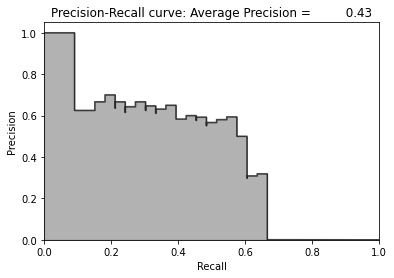

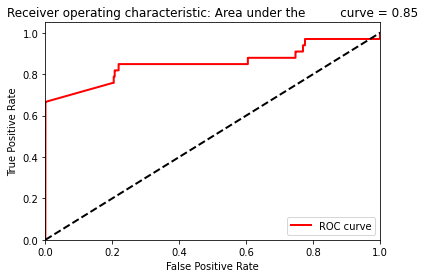

In [20]:
# Plot results
preds, average_precision = plotResults(y_train, 
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

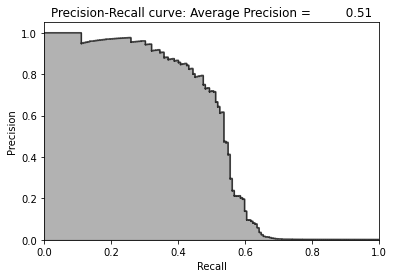

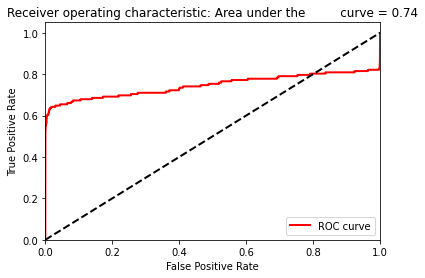

In [21]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(X_test, 
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [22]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0025


# Unsupervised Model

## Oversample

In [23]:
# Take the 33 fraudulent cases, duplicate these 100 times and then append them to the training set
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [24]:
# View shape
X_train.shape, y_train.shape

((193823, 29), (193823,))

## Design & Train Sparse Autoencoder

In [25]:
# A sparse two-layer overcomplete autoencoder with a linear a linear activation function.  
# Forty nodes in the hidden layer and a dropout of 2%

model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [26]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [27]:
# Train model
num_epochs =  5
batch_size = 32

history = model.fit(x=X_train, y=X_train, epochs=num_epochs, 
                    batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1)

Epoch 1/5
4846/4846 [==============================] - 8s 2ms/step - loss: 0.2567 - accuracy: 0.7090 - val_loss: 0.0075 - val_accuracy: 0.9819
Epoch 2/5
4846/4846 [==============================] - 7s 2ms/step - loss: 0.0188 - accuracy: 0.9248 - val_loss: 0.0624 - val_accuracy: 0.9665
Epoch 3/5
4846/4846 [==============================] - 7s 2ms/step - loss: 0.0172 - accuracy: 0.9255 - val_loss: 0.0314 - val_accuracy: 0.9761
Epoch 4/5
4846/4846 [==============================] - 7s 2ms/step - loss: 0.0168 - accuracy: 0.9257 - val_loss: 0.0394 - val_accuracy: 0.9775
Epoch 5/5
4846/4846 [==============================] - 8s 2ms/step - loss: 0.0170 - accuracy: 0.9271 - val_loss: 0.1743 - val_accuracy: 0.9594


5954/5954 [==============================] - 5s 828us/step


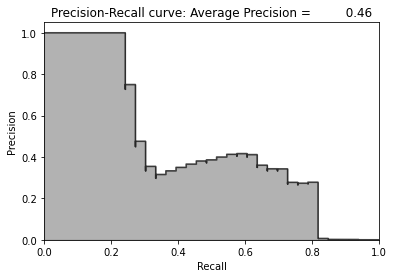

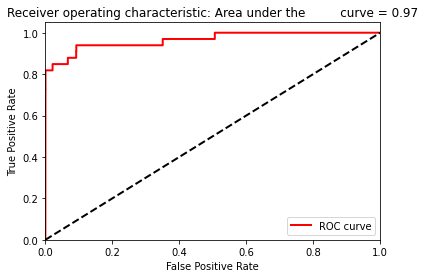

In [28]:
# Evaluate model
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, anomalyScoresAETrain, True)

2938/2938 [==============================] - 2s 832us/step


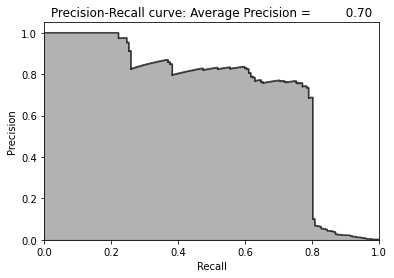

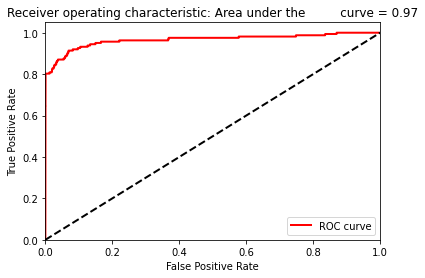

In [29]:
# Evaluate on test set
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [30]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.7593


# Semisupervised Model

## Combine Hidden Layer of Autoencoder (Learned Features) with Original Feature Set

In [31]:
# Generate hidden layer from autoencoder to pass into supervised model
layer_name = 'hidden_layer'

intermediate_layer_model  = Model(inputs=model.input, 
                                  outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test  = intermediate_layer_model.predict(X_test_original)

intermediate_output_trainDF = pd.DataFrame(data=intermediate_output_train,
                                           index=X_train_original.index)
intermediate_output_testDF  = pd.DataFrame(data=intermediate_output_test,
                                           index=X_test_original.index)

In [32]:
# Add hidden layer dimensions to original dataset
X_train = X_train_original.merge(intermediate_output_trainDF, 
                                 left_index=True,right_index=True)
X_test  = X_test_original.merge(intermediate_output_testDF, 
                                left_index=True,right_index=True)
y_train = y_train_original.copy()

## Supervised Model on Autoencoder + Original Feature Set

In [33]:
# Train and Evaluate LightGBM Model with Original + Autoencoder Dimensions
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,  columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold,num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print(f'Training Log Loss: {round(loglossTraining,4)}')
    print(f'CV Log Loss: {round(loglossCV,4)}' )

[1]	valid_0's binary_logloss: 0.0025071
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00397424
[3]	valid_0's binary_logloss: 0.00480241
[4]	valid_0's binary_logloss: 0.00412547
[5]	valid_0's binary_logloss: 0.00423491
[6]	valid_0's binary_logloss: 0.00421835
[7]	valid_0's binary_logloss: 0.00629999
[8]	valid_0's binary_logloss: 0.00630554
[9]	valid_0's binary_logloss: 0.00664475
[10]	valid_0's binary_logloss: 0.00693087
[11]	valid_0's binary_logloss: 0.00676494
[12]	valid_0's binary_logloss: 0.00670584
[13]	valid_0's binary_logloss: 0.00664706
[14]	valid_0's binary_logloss: 0.00658889
[15]	valid_0's binary_logloss: 0.00653556
[16]	valid_0's binary_logloss: 0.00648653
[17]	valid_0's binary_logloss: 0.00644594
[18]	valid_0's binary_logloss: 0.00640028
[19]	valid_0's binary_logloss: 0.00855176
[20]	valid_0's binary_logloss: 0.00780104
[21]	valid_0's binary_logloss: 0.00666008
[22]	valid_0's binary_logloss: 0.00933629
[23]	valid_0's binary_l

In [34]:
# Print results   
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(loglossLightGBMGradientBoosting,4)}')

LightGBM Gradient Boosting Log Loss: 0.0018


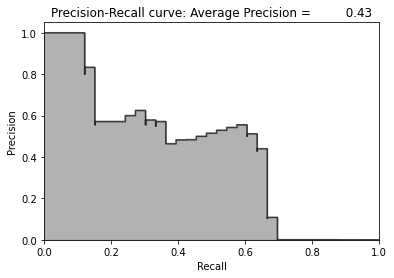

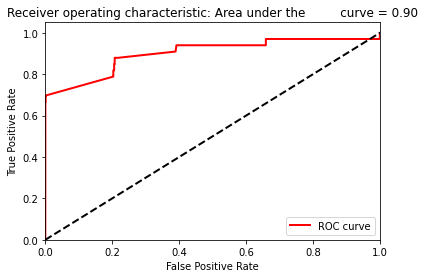

In [35]:
# Evaluate results
preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

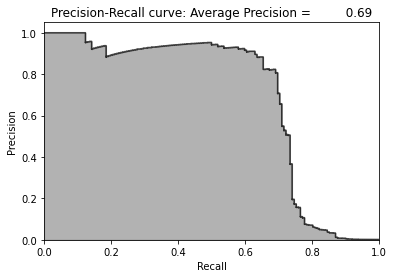

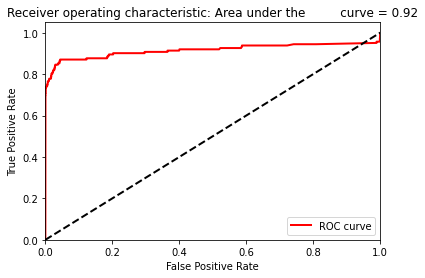

In [36]:
# Evaluate results on test set
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [37]:
# Calculate precision at 75% recall
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(f'{round(precision,4)}')

0.1577


In [38]:
# Analyze most important features
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance[:20]

,featImportance
V17,0.068061
14,0.054768
V26,0.050691
13,0.041829
V21,0.038107
31,0.037398
V12,0.034208
34,0.031195
V13,0.030663
Amount,0.029599


# Conclusion

In [39]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-05 22:02:26.547812
